In [34]:
!pip install nengolib

In [35]:
import torch
import torch.nn as nn
from sympy.matrices import Matrix, eye, zeros, ones, diag, GramSchmidt
import numpy as np
from functools import partial
import torch.nn.functional as F
import math

from nengolib.signal import Identity, cont2discrete
from nengolib.synapses import LegendreDelay
from functools import partial

def lecun_uniform(tensor):
    fan_in = nn.init._calculate_correct_fan(tensor, 'fan_in')
    nn.init.uniform_(tensor, -math.sqrt(3 / fan_in), math.sqrt(3 / fan_in))
    
class LegendreMemoryUnitCell(nn.Module):
  def __init__(self, input_dim, units , order, theta,
                 input_encoders_initializer=lecun_uniform,
                 hidden_encoders_initializer=lecun_uniform,
                 memory_encoders_initializer=partial(torch.nn.init.constant_, val=0),
                 input_kernel_initializer=torch.nn.init.xavier_normal_,
                 hidden_kernel_initializer=torch.nn.init.xavier_normal_,
                #  hidden_kernel_initializer=torch.nn.init.uniform_,
                 include_bias=False, #added by ali acc to branch
                 memory_kernel_initializer=torch.nn.init.xavier_normal_):
    super(LegendreMemoryUnitCell, self).__init__()

    self.order = order
    self.theta = theta
    self.units = units
    self.include_bias=include_bias

    realizer = Identity()
    self._realizer_result = realizer(LegendreDelay(theta=theta, order=self.order))

    self._ss = cont2discrete(self._realizer_result.realization, dt=1., method='zoh')

    self._A = self._ss.A - np.eye(order)
    self._B = self._ss.B
    self._C = self._ss.C

    self.AT = nn.Parameter(torch.Tensor(self._A), requires_grad=False)
    self.BT = nn.Parameter(torch.Tensor(self._B), requires_grad=False)

    if self.include_bias:
      self.bias = nn.Parameter(torch.Tensor(1, self.units),requires_grad=True) #added by ali for the fix given in github issue

    self.encoder_input = nn.Parameter(torch.Tensor(1,input_dim), requires_grad=True)
    self.encoder_hidden = nn.Parameter(torch.Tensor(1,self.units), requires_grad=True)
    self.encoder_memory = nn.Parameter(torch.Tensor(1,self.order ), requires_grad=True)
    self.kernel_input = nn.Parameter(torch.Tensor(self.units, input_dim), requires_grad=True)
    self.kernel_hidden = nn.Parameter(torch.Tensor(self.units, self.units), requires_grad=True)
    self.kernel_memory = nn.Parameter(torch.Tensor(self.units, self.order), requires_grad=True)
    
    if self.include_bias:
      torch.nn.init.constant_(self.bias, 0)

    input_encoders_initializer(self.encoder_input)
    hidden_encoders_initializer(self.encoder_hidden)
    memory_encoders_initializer(self.encoder_memory)
    input_kernel_initializer(self.kernel_input)
    hidden_kernel_initializer(self.kernel_hidden)
    memory_kernel_initializer(self.kernel_memory)

  def EulerOdeSolver(self):
    A_hat = (self.step_delta_t/self.theta)*self.AT + torch.eye(self.order,self.d_order_ode)
    B_hat = (self.step_delta_t/self.theta)*self.BT

    return A_hat, B_hat

  def forward(self, xt, states):
    ht, mt = states

    ut = F.linear(xt, self.encoder_input)+F.linear(ht, self.encoder_hidden)+  F.linear(mt, self.encoder_memory)


    mt = mt + F.linear(mt, self.AT) + F.linear(ut, self.BT)

    ht = nn.Tanh()(F.linear(xt, self.kernel_input) + F.linear(ht, self.kernel_hidden) + F.linear(mt, self.kernel_memory)+(self.bias if self.include_bias else 0))
    
    return ht, (ht, mt)

class LegendreMemoryUnit(nn.Module):
  def __init__(self, input_dim, units , order, theta):
    super(LegendreMemoryUnit, self).__init__()

    self.units = units
    self.order = order

    self.lmucell = LegendreMemoryUnitCell(input_dim, units , order, theta,include_bias=False)

  def forward(self, xt):
    outputs = []
    
    h0 = torch.zeros(xt.size(0),self.units).cuda()
    m0 = torch.zeros(xt.size(0),self.order).cuda()
    states = (h0,m0)
    for i in range(xt.size(1)):
      out, states = self.lmucell(xt[:,i,:], states)
      outputs += [out]
    return torch.stack(outputs).permute(1,0,2), states
    # return torch.stack(outputs).permute(1,0,2), states


# Test LMU output

In [36]:
x = torch.rand(64,5000,1).to(torch.device("cuda:0"))
h0 = torch.rand(64,49).to(torch.device("cuda:0"))
m0 = torch.rand(64,4).to(torch.device("cuda:0"))
model = LegendreMemoryUnit(1,49,4,4).to(torch.device("cuda:0"))
res, _ = model(x)
print(res.shape)

torch.Size([64, 5000, 49])


# Models LSTM - LMU

In [37]:
class LMUModel(nn.Module):
  def __init__(self):
    super(LMUModel, self).__init__()
    self.LMU = LegendreMemoryUnit(1,49,4,4)
    self.dense = nn.Linear(49,10)

  def forward(self,x):
    x, _ = self.LMU(x)
    x = self.dense(x[:,-1,:])

    return x

model_lstm = LMUModel()

print("number of parameters : ", sum(p.numel() for p in model_lstm.parameters() if p.requires_grad))
print()


number of parameters :  3200



In [38]:
class LSTMModel(nn.Module):
  def __init__(self):
    super(LSTMModel, self).__init__()
    self.LSTM = nn.LSTM(1,25,1,batch_first=True)
    self.dense = nn.Linear(25,10)

  def forward(self,x):
    x, _ = self.LSTM(x)
    x = self.dense(x[:,-1,:])

    return x
    
model_lstm = LSTMModel()

print("number of parameters : ", sum(p.numel() for p in model_lstm.parameters() if p.requires_grad))
print()


number of parameters :  3060



# MackeyGlass Datas

Took from official LMU (tensorflow) repo

# Utils

In [39]:
import numpy as np
def train(model, epochs, dataset, dataset_valid = None):
  for e in range(epochs):
      model.train()
      running_loss = 0
      sum_acc = 0      
      with tqdm(total=len(dataset)) as bar:
        for i, (X, y) in enumerate(dataset):
            optimizer.zero_grad()
            
            output = model(X.cuda())
            # print(output.shape)
            # print(y.shape)
            loss_ll = criterion(output, y.cuda())
            
            loss_ll.backward()
            
            optimizer.step()
            y_num=y.cpu().detach().numpy() 
            output_num=output.cpu().detach().numpy() 
            pred=np.argmax(output_num,axis=1)
            acc=np.sum(pred==y_num)
#             print(acc)
            sum_acc+=(acc/len(pred))
#             print(len(dataset))
#             print(len(pred))
            running_loss += loss_ll.item()

            bar.update(1)
            bar.set_description("Epoch {} - Training loss: {}, Accuracy={}".format(e, running_loss/len(dataset),sum_acc/len(dataset)))

      model.eval()
      running_loss = 0
      sum_acc = 0         
      outs = []
      with tqdm(total=len(dataset_valid)) as bar:
        for i, (X, y) in enumerate(dataset_valid):
            optimizer.zero_grad()
            
            output = model(X.cuda())
            # t1=output.detach().cpu().numpy()[0][-100:]
            # t2=y.detach().cpu().numpy()[0][-100:]
            loss_ll = criterion(output, y.cuda())
            y_num=y.cpu().detach().numpy() 
            output_num=output.cpu().detach().numpy() 
            pred=np.argmax(output_num,axis=1)
            acc=np.sum(pred==y_num)
#             print(acc)
            sum_acc+=(acc/len(pred))
#             print(pred)
#             print(y_num)
#             print(sum_acc,acc)
            running_loss += loss_ll.item()
            
            # outs.append(output)
            bar.update(1)
            bar.set_description("Epoch {} - Validation loss: {}, Accuracy={}".format(e, running_loss/len(dataset_valid),sum_acc/len(dataset_valid)))
      # plt.plot(t1)
      # plt.plot(t2)
      # plt.show()


# Test LMU vs LSTM on MackeyGlass

# New section

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
import tensorflow as tf

In [41]:
seed = 0
tf.random.set_seed(seed)
np.random.seed(seed)
rng = np.random.RandomState(seed)

In [42]:
(train_images, train_labels), (
    test_images,
    test_labels,
) = tf.keras.datasets.mnist.load_data()

In [43]:
print(len(test_images))

10000


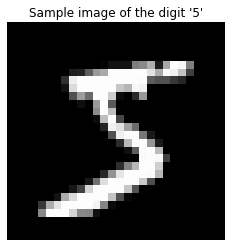

In [44]:
train_images = train_images / 255
test_images = test_images / 255

plt.figure()
plt.imshow(np.reshape(train_images[0], (28, 28)), cmap="gray")
plt.axis("off")
plt.title(f"Sample image of the digit '{train_labels[0]}'")
plt.show()

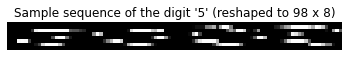

In [45]:
train_images = train_images.reshape((train_images.shape[0], -1, 1))
test_images = test_images.reshape((test_images.shape[0], -1, 1))

# we'll display the sequence in 8 rows just so that it fits better on the screen
plt.figure()
plt.imshow(train_images[0].reshape(8, -1), cmap="gray")
plt.axis("off")
plt.title(f"Sample sequence of the digit '{train_labels[0]}' (reshaped to 98 x 8)")
plt.show()

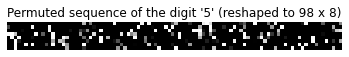

In [46]:
perm = rng.permutation(train_images.shape[1])
train_images = train_images[:, perm]
test_images = test_images[:, perm]

plt.figure()
plt.imshow(train_images[0].reshape(8, -1), cmap="gray")
plt.axis("off")
plt.title(f"Permuted sequence of the digit '{train_labels[0]}' (reshaped to 98 x 8)")
plt.show()

In [47]:
X_train = train_images[0:50000]
X_valid = train_images[50000:]
X_test = test_images

Y_train = train_labels[0:50000]
Y_valid = train_labels[50000:]
Y_test = test_labels

print(
    f"Training inputs shape: {X_train.shape}, "
    f"Training targets shape: {Y_train.shape}"
)
print(
    f"Validation inputs shape: {X_valid.shape}, "
    f"Validation targets shape: {Y_valid.shape}"
)
print(f"Testing inputs shape: {X_test.shape}, Testing targets shape: {Y_test.shape}")

Training inputs shape: (50000, 784, 1), Training targets shape: (50000,)
Validation inputs shape: (10000, 784, 1), Validation targets shape: (10000,)
Testing inputs shape: (10000, 784, 1), Testing targets shape: (10000,)


In [48]:
(train_X, train_Y_temp)= (X_train,Y_train.reshape(-1,1)) 
(test_X, test_Y_temp) = (X_test,Y_test.reshape(-1,1))
print(train_Y_temp.shape[0])
train_Y=np.zeros((train_Y_temp.shape[0],10),dtype='int')
print(test_Y_temp.shape[0])
test_Y=np.zeros((test_Y_temp.shape[0],10),dtype='int')
train_Y[np.arange(Y_train.size),Y_train] = 1
test_Y[np.arange(Y_test.size),Y_test] = 1
print(Y_train[:5])
print(train_Y[:5])
print(Y_test[:5])
print(test_Y[:5])
train_Y=Y_train
test_Y=Y_test
print(train_X.shape, test_X.shape,train_Y.shape,test_Y.shape)
print(train_X[:5000].shape)

50000
10000
[5 0 4 1 9]
[[0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]]
[7 2 1 0 4]
[[0 0 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]]
(50000, 784, 1) (10000, 784, 1) (50000,) (10000,)
(5000, 784, 1)


In [49]:
# LMU
from tqdm import tqdm
import torch.utils.data as data

# training on only 5000 and testing on 1000

model = LMUModel().cuda()
print("\n\number of paramaters : ", sum(p.numel() for p in model.parameters() if p.requires_grad))
print("\n\n")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.train()
print(model)
dataset = torch.utils.data.TensorDataset(torch.Tensor(train_X[:50000]).cuda(), torch.Tensor(train_Y[:50000]).long().cuda())
dataset = data.DataLoader(dataset, batch_size=32, shuffle=True)

dataset_valid = torch.utils.data.TensorDataset(torch.Tensor(test_X[:10000]).cuda(), torch.Tensor(test_Y[:10000]).long().cuda())
dataset_valid = data.DataLoader(dataset_valid, batch_size=16, shuffle=False)

train(model, 40, dataset, dataset_valid)

In [ ]:
# LSTM

from tqdm import tqdm
import torch.utils.data as data



model = LSTMModel().cuda()
print("\nnumber of paramaters : ", sum(p.numel() for p in model.parameters() if p.requires_grad))
print("\n\n")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.train()
print(model)
dataset = torch.utils.data.TensorDataset(torch.Tensor(train_X[:50000]).cuda(), torch.Tensor(train_Y[:50000]).long().cuda())
dataset = data.DataLoader(dataset, batch_size=16, shuffle=True)

dataset_valid = torch.utils.data.TensorDataset(torch.Tensor(test_X[:10000]).cuda(), torch.Tensor(test_Y[:10000]).long().cuda())
dataset_valid = data.DataLoader(dataset_valid, batch_size=16, shuffle=False)

train(model, 40, dataset, dataset_valid)

Epoch 0 - Training loss: 0.022197697490168075, Accuracy=0.0007987220447284345:   1%|          | 3/313 [00:00<00:09, 31.46it/s]  


number of paramaters :  3060



LSTMModel(
  (LSTM): LSTM(1, 25, batch_first=True)
  (dense): Linear(in_features=25, out_features=10, bias=True)
)


Epoch 0 - Training loss: 2.282665211552629, Accuracy=0.12280351437699681: 100%|██████████| 313/313 [00:10<00:00, 31.00it/s]   
Epoch 0 - Validation loss: 2.201162089920044, Accuracy=0.2173: 100%|██████████| 625/625 [00:10<00:00, 62.41it/s]  
Epoch 1 - Training loss: 2.1057528036470994, Accuracy=0.2250399361022364: 100%|██████████| 313/313 [00:09<00:00, 32.10it/s]    
Epoch 1 - Validation loss: 2.010354955673218, Accuracy=0.2476: 100%|██████████| 625/625 [00:11<00:00, 56.53it/s]  
Epoch 2 - Training loss: 2.0067668025866867, Accuracy=0.25579073482428116: 100%|██████████| 313/313 [00:09<00:00, 31.95it/s]  
Epoch 2 - Validation loss: 1.967241650390625, Accuracy=0.2794: 100%|██████████| 625/625 [00:09<00:00, 63.56it/s]  
Epoch 3 - Training loss: 1.9607706359400154, Accuracy=0.27376198083067094: 100%|██████████| 313/313 [00:09<00:00, 32.56it/s]  
Epoch 3 - Validation loss: 1.8955079917907716, Accuracy=0.3216: 100%|██████████| 625/625 [00:10<00:00, 58.13it/s] 
Epoch 4 - Training loss: 1.8893